PROBLEMATIQUE DE NOTRE ETUDE:
# “How can the European bank identify and predict key factors driving customer churn, and what strategies can be implemented to reduce churn based on customer profiles and behavior patterns?”

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
df_full = pd.read_csv("churn_bank.csv") # if already in the repo, otherwise use the full path

As we saw previously (in the first part) around 20% of the customers have exited the bank. In the following part we try to identify and predict key factors driving customers churn. In this way banks can possibly reduce this number based on customer profiles and behavior patterns. 

# Correlation Analysis

Global view. Let's build a correlation matrix to get a first idea of what might affect churn

[Text(0.5, 1.0, 'Overview: Correlation matrix')]

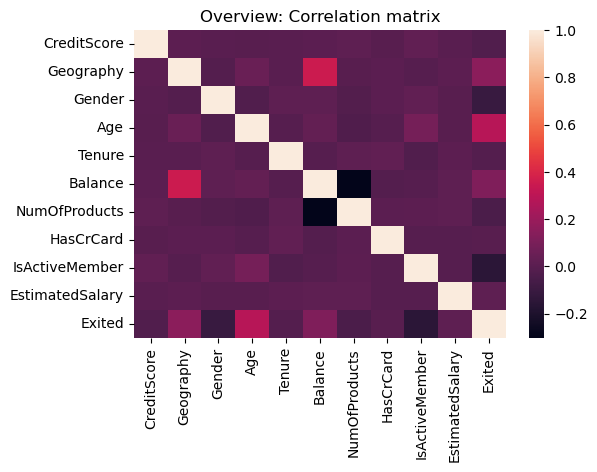

In [4]:
# correlation matrix only takes numerical values not string. 
# therefore we transform the Geography and Gender as numerical values (dummies).
COUNTRY = {"France":"1",
        "Spain":"2",
        "Germany":"3"}
GENDER = {"Female":"1",
        "Male":"2"}

df_corr = df_full.copy()
df_corr.replace({'Geography': COUNTRY, 'Gender': GENDER}, inplace=True) 

df_corr = df_corr.drop(columns=["Surname", "CustomerId"])
# computing it
matrix_corr = df_corr.corr()
# plotting
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(matrix_corr)
# title and axis labels
ax.set(
    title="Overview: Correlation matrix"
)

# save the figs for after - plt.savefig('CorrelationMatrix_1.png')

Strongest correlation

- Geography - Exited. Ok maybe they churn more a certain country easy to check. 
- Age - Exited. 
- Balance - Exited 
   
- Balance - Geography (something to look at in part 1 with maybe Germany VS the other countries. 
Maybe the balance = 0 est concentré plus dans un pays que dans les autres)
- Nbr of products - Exited (mais very little et ça peut être du au très faible nombre de customer avec 3 ou 4 products)
- Age - Is active member (very little aussi mais à check) 

### Customer profile: Geography, Age and Gender

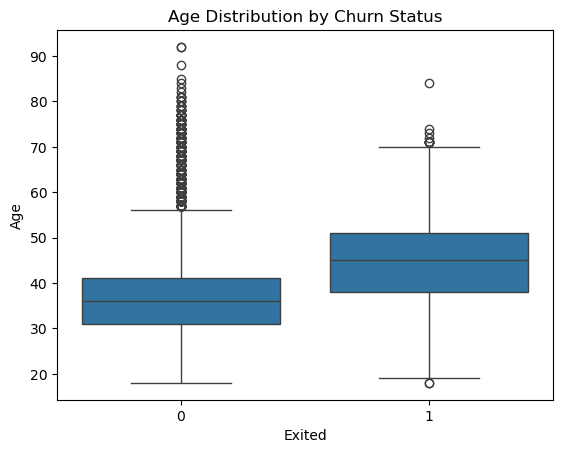

In [10]:
# 1. How does Age interactw with churn ? 

sns.boxplot(x='Exited', y='Age', data=df_full) 
plt.title('Age Distribution by Churn Status') 
plt.show()

- Seems like Customers who churned are generally older, with the median age being higher compared to non-churned customers. 
- The Interquartile Range (25th percentile - 75th percentile) seem larger for churned customers: more variability in their ages compared to non-churned customers. [not churn : most ages fall between roughly 30 and 45. churned : most ages are between approximately 45 and 60.]
- A lot of outliers for the non-churned one at older age. Some older customers stayed, they are not representative of the typical customer who did not churn?
- Customers who did not churn have a more concentrated age range (roughly 20 to 55), while customers who churned have a wider range, spreading from about 20 to 70 et plus.

Overall : older customers appear more likely to churn (comme on le voit avec the higher median age and the wider age distribution in the churned group). + Non-churned customers are generally younger, with a more concentrated age range, suggesting that the bank may be more successful in retaining younger clients.

/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_59067/4186215334.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate_by_age = df_full.groupby('Age_group')['Exited'].mean()


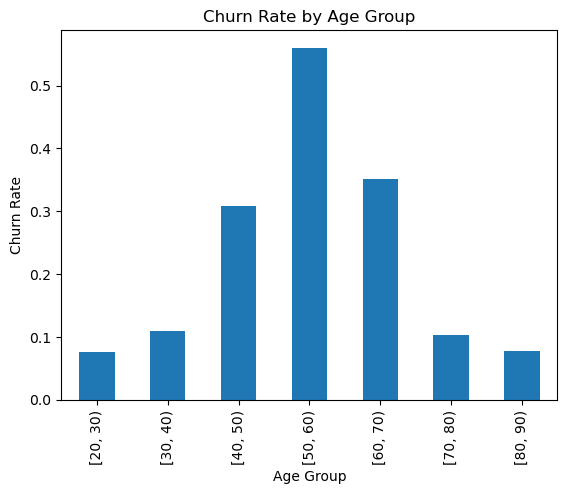

In [20]:
# OK but these results bight be driven by the age distribution in the dataset.
# We need to control for the fact that in the overall dataset we have way more younger people, big concentration of people between 25 and 45 years old.
# Create age groups (e.g., bin ages into 10-year intervals)

df_full['Age_group'] = pd.cut(df_full['Age'], bins=[20, 30, 40, 50, 60, 70, 80, 90], right=False) 
# Calculate churn rate per age group 
churn_rate_by_age = df_full.groupby('Age_group')['Exited'].mean() 
churn_rate_by_age.plot(kind='bar') 
plt.title('Churn Rate by Age Group') 
plt.ylabel('Churn Rate') 
plt.xlabel('Age Group') 
plt.show()


In [22]:
## this part is more prediction - logisitc regression model

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 

X = df_full[['Age']] 
y = df_full['Exited'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

model = LogisticRegression() 
model.fit(X_train, y_train) 

# show how much age influences churn
print(f"Coefficient for Age: {model.coef_[0][0]}")

Coefficient for Age: 0.06274384470379325


Holding all else constant, for every 1 year increase in age, the (log?)odds of a customer churning increases by almost 6.5% (cause log) - in lign with the above results showing that older customers are more likely to churn. 

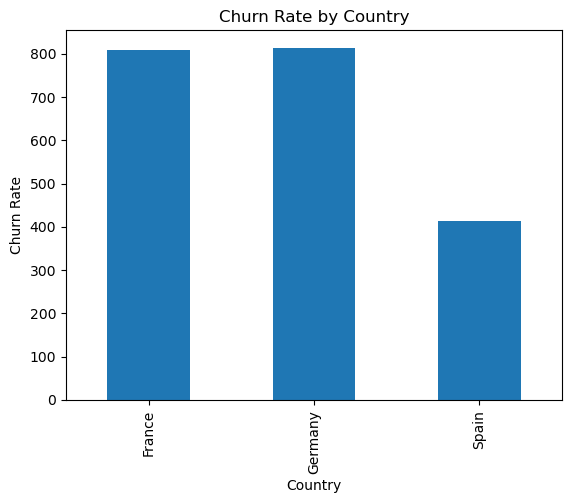

In [40]:
# 2. How does Geography interactw with churn ? 

df_full[df_full['Exited'] == 1].groupby('Geography')['Exited'].count().plot(kind='bar') 
plt.title('Churn Rate by Country') 
plt.ylabel('Churn Rate') 
plt.xlabel('Country') 
plt.show()



Seems inconsistent avec ce qu'avait trouvé sofia en terme de proportions ?

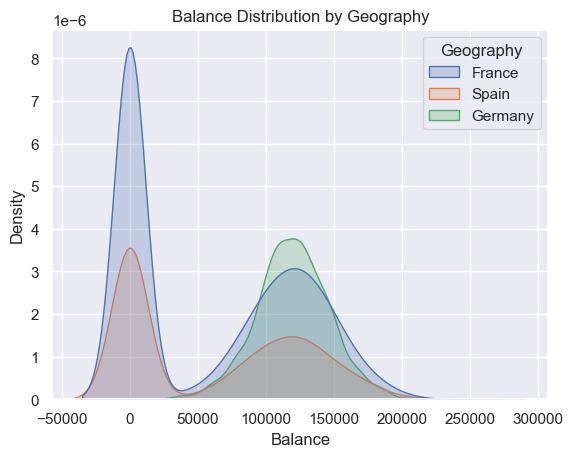

In [47]:
# Quick look how does Balance interact with Geography - and therefore after how is it interacting with churn ?

sns.kdeplot(data=df_full, x="Balance", hue="Geography", fill=True) 
plt.title('Balance Distribution by Geography') 
plt.xlabel('Balance') 
plt.ylabel('Density') 
plt.show() 

# CHECK - for negative balance
# xx = df_full.loc[df_full['Balance'] < 0]

The proportion of people whose balance is at 0 are mostly in France. 

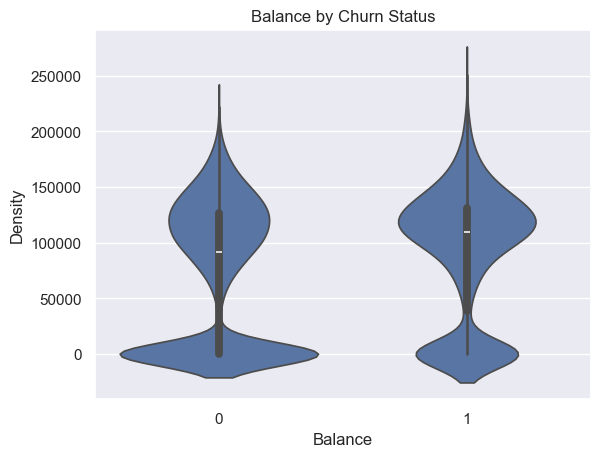

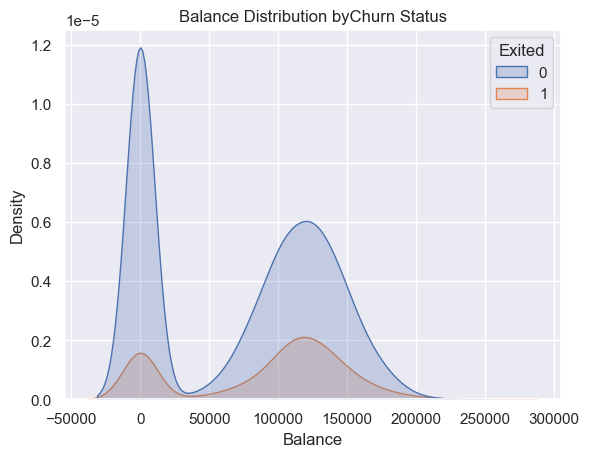

In [52]:
# Most null balance are in France. But is the balance actually a good predict key factor driving customer to churn ? 
# (if yes we should see a bigger proportion of people churning in France which is not the case but ok let's have a look)

sns.violinplot(y="Balance", x="Exited", data=df_full)
plt.title('Balance by Churn Status') 
plt.xlabel('Balance') 
plt.ylabel('Density') 
plt.show() 

# other option visual
sns.kdeplot(data=df_full, x="Balance", hue="Exited", fill=True) 
plt.title('Balance Distribution byChurn Status') 
plt.xlabel('Balance') 
plt.ylabel('Density') 
plt.show() 

# not convinced 


### Financial Analysis 

### Activity analysis